## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.

### Dataset

In this homework, we will use the Students Performance in 2024 JAMB dataset from [Kaggle](https://www.kaggle.com/datasets/idowuadamo/students-performance-in-2024-jamb).

Here's a wget-able [link](https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv):

```bash
wget https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv
```

The goal of this homework is to create a regression model for predicting the performance of students on a standardized test (column `'JAMB_Score'`).


In [2]:
!wget https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv -O ./data/jamb_exam_results.csv

--2024-11-11 07:58:50--  https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alexeygrigorev/datasets/refs/heads/master/jamb_exam_results.csv [following]
--2024-11-11 07:58:51--  https://raw.githubusercontent.com/alexeygrigorev/datasets/refs/heads/master/jamb_exam_results.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 391501 (382K) [text/plain]
Saving to: ‘./data/jamb_exam_results.csv’

./data/jamb_exam_re 100%[===================>] 382.33K   979KB/s    in 0.4s    

2024-11-11 07:58:52 (979 KB/s) - ‘./data

In [28]:
#import all necessary libraries
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

from IPython.display import display
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import root_mean_squared_error

%matplotlib inline

In [4]:
df=pd.read_csv('./data/jamb_exam_results.csv')
df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


In [6]:
print(df.shape)
df.info()

(5000, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   JAMB_Score                    5000 non-null   int64  
 1   Study_Hours_Per_Week          5000 non-null   int64  
 2   Attendance_Rate               5000 non-null   int64  
 3   Teacher_Quality               5000 non-null   int64  
 4   Distance_To_School            5000 non-null   float64
 5   School_Type                   5000 non-null   object 
 6   School_Location               5000 non-null   object 
 7   Extra_Tutorials               5000 non-null   object 
 8   Access_To_Learning_Materials  5000 non-null   object 
 9   Parent_Involvement            5000 non-null   object 
 10  IT_Knowledge                  5000 non-null   object 
 11  Student_ID                    5000 non-null   int64  
 12  Age                           5000 non-null   int64

In [7]:
df.isnull().sum()

JAMB_Score                        0
Study_Hours_Per_Week              0
Attendance_Rate                   0
Teacher_Quality                   0
Distance_To_School                0
School_Type                       0
School_Location                   0
Extra_Tutorials                   0
Access_To_Learning_Materials      0
Parent_Involvement                0
IT_Knowledge                      0
Student_ID                        0
Age                               0
Gender                            0
Socioeconomic_Status              0
Parent_Education_Level          891
Assignments_Completed             0
dtype: int64

### Preparing the dataset 

First, let's make the names lowercase:

```python
df.columns = df.columns.str.lower().str.replace(' ', '_')
```

Preparation:

* Remove the `student_id` column.
* Fill missing values with zeros.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [13]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns 

Index(['jamb_score', 'study_hours_per_week', 'attendance_rate',
       'teacher_quality', 'distance_to_school', 'school_type',
       'school_location', 'extra_tutorials', 'access_to_learning_materials',
       'parent_involvement', 'it_knowledge', 'student_id', 'age', 'gender',
       'socioeconomic_status', 'parent_education_level',
       'assignments_completed'],
      dtype='object')

In [14]:
#removing student_id column
del df['student_id']

In [16]:
#filling the missing values with zeros
df['parent_education_level']=df.parent_education_level.fillna(0)

In [19]:
#splitting the dataset
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.2, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.jamb_score 
y_val = df_val.jamb_score 
y_test = df_test.jamb_score 

del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']

In [20]:
#turning dataframes to matrix
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)

## Question 1

Let's train a decision tree regressor to predict the `jamb_score` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `study_hours_per_week`
* `attendance_rate`
* `teacher_quality`
* `distance_to_school`


In [23]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [24]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- study_hours_per_week <= 18.50
|   |--- value: [156.06]
|--- study_hours_per_week >  18.50
|   |--- value: [188.77]



Answer: study_hours_per_week

## Question 2

Train a random forest regressor with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on the validation data?

* 22.13
* 42.13
* 62.13
* 82.12

In [27]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [29]:
y_pred = rf.predict(X_val)

root_mean_squared_error(y_val,y_pred)

np.float64(41.60899752457394)

Answer: 42.13

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for calculating the answer.

- 10
- 25
- 80
- 200


In [53]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse =root_mean_squared_error(y_val,y_pred)
    
    scores.append((n, rmse))

In [54]:
df_scores=pd.DataFrame(scores,columns=['n_estimators','rmse'])

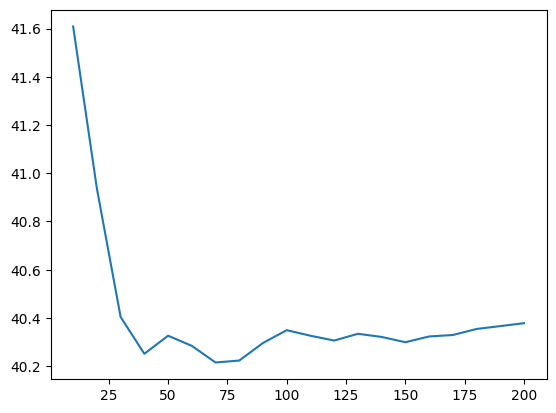

In [55]:
#plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

plt.show()

Answer: 80 (70)

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`


What's the best `max_depth`, using the mean RMSE?

* 10
* 15
* 20
* 25

In [33]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=1,
                                    n_jobs=-1
                                    )
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict(X_val)
        rmse =root_mean_squared_error(y_val,y_pred)

        scores.append((d, n, rmse))

In [34]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

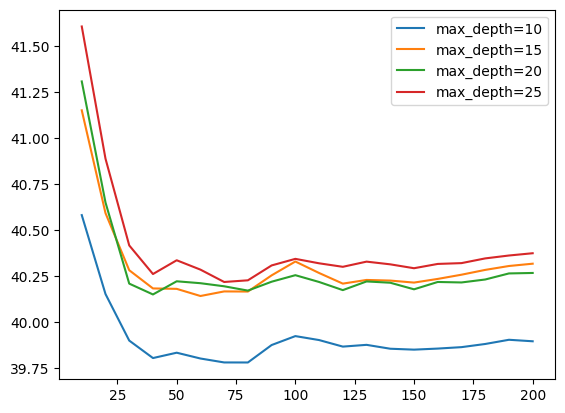

In [36]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()

Answer: 10

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `study_hours_per_week`
* `attendance_rate`
* `distance_to_school`
* `teacher_quality`


In [37]:
rf = RandomForestRegressor(n_estimators=10,
                            max_depth=20,
                            random_state=1,
                            n_jobs=-1
                            )
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [38]:
rf.feature_importances_

array([0.01094609, 0.01008961, 0.0668335 , 0.03139094, 0.15118005,
       0.14134736, 0.00952129, 0.00981117, 0.01129091, 0.00898984,
       0.0221945 , 0.01240691, 0.01235437, 0.        , 0.01535858,
       0.01413879, 0.01439532, 0.02276782, 0.01479034, 0.01069137,
       0.00988814, 0.00979223, 0.00990396, 0.00937294, 0.02315288,
       0.01359314, 0.01423341, 0.23924465, 0.08031991])

In [44]:
# Built-in feature importance (Gini Importance)
importances = rf.feature_importances_
feature_names=list(dv.get_feature_names_out())
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
feature_imp_df.sort_values(by='Gini Importance',ascending=False).head()

,Feature,Gini Importance
27,study_hours_per_week,0.239245
4,attendance_rate,0.151180
5,distance_to_school,0.141347
28,teacher_quality,0.080320
2,age,0.066834


Answer: study_hours_per_week	

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value

In [45]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)


In [48]:
score=dict()

In [51]:

xgb_params = {
    # 'eta': 0.3, 
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100) 

y_pred = model.predict(dval)
rmse=root_mean_squared_error(y_val,y_pred)

score[xgb_params['eta']]=rmse

In [52]:
score

{0.3: np.float64(42.37919586079883), 0.1: np.float64(40.19582382984711)}

Answer: 0.1